# HW7 The Great BDD Notebook
Apologies for the late arrival of this homework. I found that while the packages I had planned to use mostly worked, there were two issues:
* They required local install of a binary package -- I have no simple way to do that with the leading BDD package (CUDD). I sent an inordinate amount of time trying to get working binaries on the lab machines... They work but are very far from convenient.
* Lack of decent documentation. Although my students built good code, they were maybe not so good at writing it up for people outside of the group.

As is happens, I found a version by a group I have helped in the past at Caltech. They built a pure python bdd package that while not up to the CUDD standard, is eminently portable. The package is called DD and is part of the temporal logic work, thus: tulip-control/dd and tulip-control/omega
Both packages are available from Pypi so can be installed via pip. The packages us ATT graphviz, but you should already have that. Please install now, and restart Jupyterlab.

In [1]:
# pip install dd
# pip install omega

### Overview
BDD packages are organized as managers, which coincide with Python classes. This is because all bdd operations assume that the BDDs in question have identical variable orders. This order is managed by the manager, and it is possible to have multiple managers and to even pass bdds between managers, but doing so is not free.

So, a bit similar to Docplex, you need to allocate variables to the package. DD provides the interface and additionally provides a parser that can translate Boolean expressions in two alternative formats: Promela and TLA+, additionally, you can use the overloaded operators specific to the new variables. Remember, a a variable is a reference to a bdd node and thus a Boolean function. A bdd package is not a solver or an optimizer, but since it provides a canonical representation, can effectively do both.

For example, if you build a bdd representing a CNF clause family the resulting function will be a Boolean function representing all possible variable settings that satisfy the CNF. If UNSAT you get 0. BDDs are often compressed representations, but since they are always complete, they can easily be too large to manipulate. This is definitely a case of be very careful of what you ask for...

Similarly, if you create a tautology, no matter how complex, the result will simply be '1'. Lets try that out:

In [2]:
from dd.autoref import BDD
#make a bdd manager
mgr = BDD()
#declare some variables. These are allocated named levels in the manager
#note -- this does not make them bdd nodes!
mgr.declare('x', 'y', 'z', 'w')

u = mgr.add_expr(r'((~x & y) | z ) => ((~x & y) |z)')
print(u.to_expr())

TRUE


In is also possible to plot the nodes present in the manager:

In [3]:
from IPython.display import IFrame, display
mgr.dump('test.pdf')
IFrame('test.pdf', width=500, height=350)

The manager, in creating this result, created several functions on the way to building u, since u was a parser based prescription. Since there are no references to these nodes, they can be garbage collected. Note: you can directly change the reference count for nodes using .incref() and .decref() methods. You can ensure that a reference  persists by manually incrementing is reference count -- so it cannot be collected.

In [4]:
print(len(mgr)) #nodes in bdd before collection
mgr.collect_garbage()
print(len(mgr)) #nodes after collection (u is still an active python reference)

7
1


In [5]:
from IPython.display import IFrame, display
mgr.dump('test.pdf')
IFrame('test.pdf', width=500, height=350)

Beyond propositional logic, BDDs easily describe the results of first-order Boolean logic constructions (i.e. quantifiers) as well as much more general Boolean operators such as substitution (i.e. mapping variables to other names).
For example:

In [6]:
mgr.collect_garbage()
v = mgr.add_expr(r'x&~y | x&z | ~x&w')
print(v.to_expr())
mgr.dump('test.pdf')
IFrame('test.pdf', width=500, height=350)

ite(x, ite(y, z, TRUE), w)


In [7]:
s = mgr.exist(['y'], v)
print(s.to_expr())
mgr.dump('test.pdf')
IFrame('test.pdf', width=500, height=350)

ite(x, TRUE, w)


In [8]:
t = mgr.add_expr(r'\E y: (x&~y | x&z | ~x&w)') #r (raw) is used to allow backslash
if (s == t) :
    print('bdds match!')

bdds match!


### Variable order (levels)
BDDs are extremely sensitive to variable order for functions with strongly related variables -- in general, such variables should be as close together as possible. Fortunately, there is a built-in reordering mechanism to optimize the order. Be careful with large functions as it might not be possible to reorder functions if the intermediate sizes are too large.

Creating a new manager:

In [9]:
mgr2 = BDD()
variables = ['x{i}'.format(i=i) for i in range(4)]
variables.extend('y{i}'.format(i=i) for i in range(4))
print(variables)
mgr2.declare(*variables)
mgr2.vars #prints variable names and the relevent bdd level

['x0', 'x1', 'x2', 'x3', 'y0', 'y1', 'y2', 'y3']


{'x0': 0, 'x1': 1, 'x2': 2, 'x3': 3, 'y0': 4, 'y1': 5, 'y2': 6, 'y3': 7}

In [10]:
u = mgr2.add_expr('x0&y0 | x1&y1 | x2&y2 | x3&y3')
mgr2.incref(u) #force extra reference so cannot garbage collect
len(u) #number of nodes in the bdd representing u

31

In [11]:
mgr2.collect_garbage()
mgr2.dump('test.pdf')
IFrame('test.pdf', width=800, height=450)

This bdd has a very unfortunate default order -- it would have been far better to interleave the x and y variables given their relation in the function u. If we reorder
the manager (note - you can only reorder a manager, not a function!), life is much better:

In [12]:
BDD.reorder(mgr2)
print(len(u))

11


In [13]:
mgr2.dump('test.pdf',[u]) #just plot the bdd we care about
IFrame('test.pdf', width=350, height=650)

### Problem 1
In this problem, you get to revisit the graph coloring problem. In the previous incantation, you created a large cnf and then checked for a satisfiable assignment of colors. If you build a bdd of that same cnf for a color bound that is feasible, it will be the set of all possible satisfying assignments to the same coloring problem.
While redundant logic had a place in the SAT case, here, up to variable order, you get the same function regardless of the order of construction. However, you don't get the same build time since the construction process builds partial functions that may be eliminated by subsequent operations of the manager. In fact, it can be that some constraints are exponentially large, even if the bdd, once built, is reasonably small.
At the same time, while you can reorder in place periodically, it pays to choose an initial variable order that groups heavily related variables together.

Given that you already have CNF constructions for the coloring problem, it might be sensible to build a clause converter that takes a list of clauses and constructs a bdd from that. If the clause set get large, you can save time by directly calling the package rather than using the dd expression parser. For tiny cases, like the test case below, it probably doesn't matter, but you always need to think about variable order.
Note, if the color assignment is too small, the bdd will simply return 'False', however, unlike SAT if the assignment is way too large, the bdd will record all possible valid colorings -- which will likely explode the size.

In [14]:
'''

In this problem, I use a binary search method to reach the optimum minimum coloring in a faster manner. All different potential constraint order
were explored and the reasoning and obervations along with some performance tests have been provided in places. 

Initially tried using .add_Expr() to incrementally add clauses - but that apparantly does not work and the BDD requires passing all clauses at once.
Used a string to append a list of clauses in general ANDING format. Also noted that there is no strict requirement of "And of ORs "
 or "OR of ANDs" and the ITE provides much flexibility in terms of represnetation. 
'''

'\n\nIn this problem, I use a binary search method to reach the optimum minimum coloring in a faster manner. All different potential constraint order\nwere explored and the reasoning and obervations along with some performance tests have been provided in places. \n\nInitially tried using .add_Expr() to incrementally add clauses - but that apparantly does not work and the BDD requires passing all clauses at once.\nUsed a string to append a list of clauses in general ANDING format. Also noted that there is no strict requirement of "And of ORs "\n or "OR of ANDs" and the ITE provides much flexibility in terms of represnetation. \n'

In [15]:
# Import Pandas, numpy and Networkx

from omega.logic.syntax import conj, disj
import numpy as np
import pandas as pd
import networkx as nx
import scipy as sp
import random
import time
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)

In [16]:
N = 8
edges= [[0,1],[0,3],[0,4],[1,2],[1,6],[2,5],[2,6],[3,5],[4,7],[5,6],[6,7]]

In [17]:
G = nx.Graph()
G.add_edges_from(edges)
G.add_nodes_from([i for i in range(0,N)])

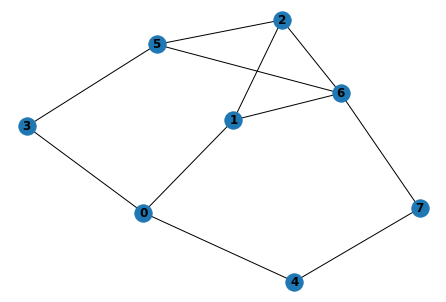

matrix([[0, 1, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 1, 0, 1, 1],
        [0, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0]], dtype=int32)

In [18]:
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()
A = nx.adjacency_matrix(G)
Adj = A.todense()
Adj

In [19]:
from dd import autoref as _bdd
bdd = _bdd.BDD()

In [20]:
# IDEA is to iteratively search for minimum number of colors that can still satisfy the constraints

# Best solution is binary search, keep going left until left > right
left = 2
right = N
mid = int(N/2)
min_color_soln = N

while left <= right :  
    """
    Construct the BDD for allowed number of colors
    """    
    
    mid = int ((left + right) /2 )
    num_colors = mid
    print("Current Mid (number of colors) is", mid)
    
    string = ''
    mgr3 = BDD()
    variables = ['x{i}{j}'.format(i=i, j=j) for i in range(N) for j in range(num_colors)]
    # variables.extend('y{i}'.format(i=i) for i in range(N))
    print(variables)
    mgr3.declare(*variables)
    mgr3.vars #prints variable names and the relevent bdd level
    
    # Color definedeness per node constraint
    for i in range(N):
        clause = '('
        clause += 'x{i}{j}'.format(i=i, j= 0)
        for j in range(1, num_colors):
            clause += ' | ' + 'x{i}{j}'.format(i=i, j=j)
        clause += ')'  
        if i==0 :
            string += clause
        else:
            string += ' & ' + clause

    # Color uniqueness per node constraint  
    for i in range(N):
        for j in range(num_colors):
            for k in range(j+1, num_colors):
                # if i== 0 and j==0 and k==1:
                #    string += '(!x{i}{j} | !x{i}{k})'.format(i=i, j=j, k=k)
                # else:
                string += ' & ' + '(!x{i}{j} | !x{i}{k})'.format(i=i, j=j, k=k)

    """ 
    # Color definedeness per node constraint
    for i in range(N):
        clause = '('
        clause += 'x{i}{j}'.format(i=i, j= 0)
        for j in range(1, num_colors):
            clause += ' | ' + 'x{i}{j}'.format(i=i, j=j)
        clause += ')'    
        string += ' & ' + clause
    """
    # Constraint 3: For all edges: no two vertex share same colour
    for e in edges:
        # e[0] -> gives left-vertex, e[1] -> gives right-vertex
        clause = ''
        for k in range(num_colors):
            clause = '!(x{i}{k} & x{j}{k})'.format(i=e[0], j=e[1], k=k)
            string += ' & ' + clause
            
    print(string)
    u= mgr3.add_expr(string)
    print("Before size", len(u))
    BDD.reorder(mgr3)
    print("After size", len(u))
    print(u)
    
    if u.to_expr() != "FALSE":
        print("Solution exists for {n} colors".format(n= num_colors))
        right = mid - 1 
        if mid< min_color_soln:
            min_color_soln = mid
        if mid == 3:
            mgr3.dump('test.pdf')
            models = list(mgr3.pick_iter(u))
    else:
        print("No Solution for {n} colors".format(n= num_colors))
        left = mid + 1
    
    mgr3.collect_garbage()
    
print("Last num of colors tried: ", mid)

Current Mid (number of colors) is 5
['x00', 'x01', 'x02', 'x03', 'x04', 'x10', 'x11', 'x12', 'x13', 'x14', 'x20', 'x21', 'x22', 'x23', 'x24', 'x30', 'x31', 'x32', 'x33', 'x34', 'x40', 'x41', 'x42', 'x43', 'x44', 'x50', 'x51', 'x52', 'x53', 'x54', 'x60', 'x61', 'x62', 'x63', 'x64', 'x70', 'x71', 'x72', 'x73', 'x74']
(x00 | x01 | x02 | x03 | x04) & (x10 | x11 | x12 | x13 | x14) & (x20 | x21 | x22 | x23 | x24) & (x30 | x31 | x32 | x33 | x34) & (x40 | x41 | x42 | x43 | x44) & (x50 | x51 | x52 | x53 | x54) & (x60 | x61 | x62 | x63 | x64) & (x70 | x71 | x72 | x73 | x74) & (!x00 | !x01) & (!x00 | !x02) & (!x00 | !x03) & (!x00 | !x04) & (!x01 | !x02) & (!x01 | !x03) & (!x01 | !x04) & (!x02 | !x03) & (!x02 | !x04) & (!x03 | !x04) & (!x10 | !x11) & (!x10 | !x12) & (!x10 | !x13) & (!x10 | !x14) & (!x11 | !x12) & (!x11 | !x13) & (!x11 | !x14) & (!x12 | !x13) & (!x12 | !x14) & (!x13 | !x14) & (!x20 | !x21) & (!x20 | !x22) & (!x20 | !x23) & (!x20 | !x24) & (!x21 | !x22) & (!x21 | !x23) & (!x21 | !x2

In [21]:
IFrame('test.pdf', width=1000, height=600)

In [22]:
print("Minimum number of colors for this graph is", min_color_soln)
print("One of the solutions of the model is", models[0])

Minimum number of colors for this graph is 3
One of the solutions of the model is {'x01': False, 'x00': False, 'x02': True, 'x30': False, 'x10': True, 'x50': True, 'x12': False, 'x11': False, 'x52': False, 'x32': False, 'x51': False, 'x31': True, 'x22': False, 'x21': True, 'x20': False, 'x41': False, 'x40': True, 'x61': False, 'x60': False, 'x70': False, 'x71': True, 'x42': False, 'x72': False, 'x62': True}


### Problem 2
As you know, the SAT solver worked very well for low to medium density graphs, but high density problems rapidly became intractable. This is due to two reasons:
* The number of large intersecting cliques grows rapidly with density
* The number of colorings grows factorially fast with the number of colors
In recasting this problem on BDDs, you effectively have 4 sets of constraints:
* The edges which force different color assignments
* The uniqueness constraint on color choice
* Forcing some color to be chosen
* Any symmetry breaking constraints
Build a few 8 node graphs with densities of [0.8..0.95]. Try different variable orders and construction orders as well as garbage collection and reordering to find a more efficient scheme for building these difficult cases. Describe the scheme you choose and why. Note: if you remove the uniqueness constraint, what happens to the bdd size? If there is a change, can you explain it?

It makes sense to find a large clique in the test case and pre-color it to break symmetry. While finding the maximum clique is hard, it is easy to chose a node with large edge count and add connected edges to it checking that the new vertex to add connects to all the vertexes in the trial clique. This stops when no new vertex can be added. For high density graphs, such a procedure often finds a good size clique to pre-color.

Using your optimized construction, can you color these high density graphs of size 14, 18, 20? What happens as density approaches 1.0?

In [23]:
def randgraph(N, d):
    edges = []
    for i in range(N):
        for j in range(N):
            if i!=j and random.randint(0, 1) <= d :
                edges.append([i,j])
            
    return N, len(edges), edges       

 ############################# N = 8 d = 0.8 Run = 1 ###############################


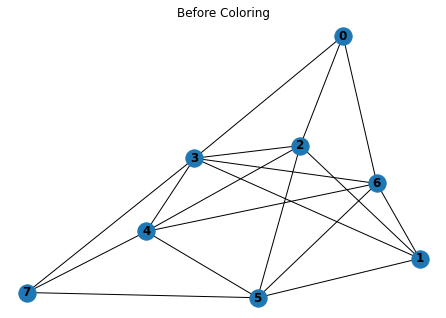

Current Mid (number of colors) is 5
['x00', 'x01', 'x02', 'x03', 'x04', 'x10', 'x11', 'x12', 'x13', 'x14', 'x20', 'x21', 'x22', 'x23', 'x24', 'x30', 'x31', 'x32', 'x33', 'x34', 'x40', 'x41', 'x42', 'x43', 'x44', 'x50', 'x51', 'x52', 'x53', 'x54', 'x60', 'x61', 'x62', 'x63', 'x64', 'x70', 'x71', 'x72', 'x73', 'x74']
Before u1 length 4554
After u1 length 2723
Solution exists for 5 colors
Current Mid (number of colors) is 3
['x00', 'x01', 'x02', 'x10', 'x11', 'x12', 'x20', 'x21', 'x22', 'x30', 'x31', 'x32', 'x40', 'x41', 'x42', 'x50', 'x51', 'x52', 'x60', 'x61', 'x62', 'x70', 'x71', 'x72']
Before u1 length 99
After u1 length 76
Solution exists for 3 colors
Current Mid (number of colors) is 2
['x00', 'x01', 'x10', 'x11', 'x20', 'x21', 'x30', 'x31', 'x40', 'x41', 'x50', 'x51', 'x60', 'x61', 'x70', 'x71']
Before u1 length 1
After u1 length 1
No Solution for 2 colors
Minimum number of colors for this graph is 3
Last num of colors tried:  2
 ############################# N = 8 d = 0.8 Run = 2 

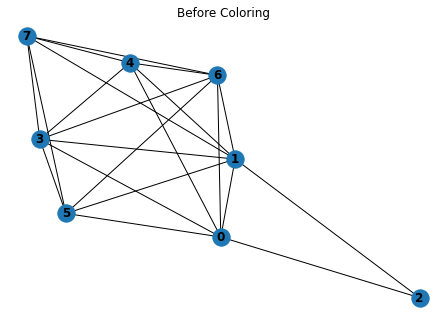

Current Mid (number of colors) is 5
['x00', 'x01', 'x02', 'x03', 'x04', 'x10', 'x11', 'x12', 'x13', 'x14', 'x20', 'x21', 'x22', 'x23', 'x24', 'x30', 'x31', 'x32', 'x33', 'x34', 'x40', 'x41', 'x42', 'x43', 'x44', 'x50', 'x51', 'x52', 'x53', 'x54', 'x60', 'x61', 'x62', 'x63', 'x64', 'x70', 'x71', 'x72', 'x73', 'x74']
Before u1 length 1007
After u1 length 568
Solution exists for 5 colors
Current Mid (number of colors) is 3
['x00', 'x01', 'x02', 'x10', 'x11', 'x12', 'x20', 'x21', 'x22', 'x30', 'x31', 'x32', 'x40', 'x41', 'x42', 'x50', 'x51', 'x52', 'x60', 'x61', 'x62', 'x70', 'x71', 'x72']
Before u1 length 1
After u1 length 1
No Solution for 3 colors
Current Mid (number of colors) is 4
['x00', 'x01', 'x02', 'x03', 'x10', 'x11', 'x12', 'x13', 'x20', 'x21', 'x22', 'x23', 'x30', 'x31', 'x32', 'x33', 'x40', 'x41', 'x42', 'x43', 'x50', 'x51', 'x52', 'x53', 'x60', 'x61', 'x62', 'x63', 'x70', 'x71', 'x72', 'x73']
Before u1 length 1
After u1 length 1
No Solution for 4 colors
Minimum number of colo

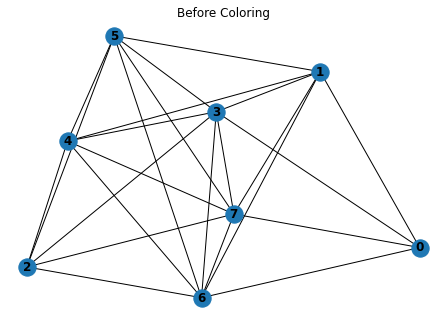

Current Mid (number of colors) is 5
['x00', 'x01', 'x02', 'x03', 'x04', 'x10', 'x11', 'x12', 'x13', 'x14', 'x20', 'x21', 'x22', 'x23', 'x24', 'x30', 'x31', 'x32', 'x33', 'x34', 'x40', 'x41', 'x42', 'x43', 'x44', 'x50', 'x51', 'x52', 'x53', 'x54', 'x60', 'x61', 'x62', 'x63', 'x64', 'x70', 'x71', 'x72', 'x73', 'x74']
Before u1 length 1
After u1 length 1
No Solution for 5 colors
Current Mid (number of colors) is 7
['x00', 'x01', 'x02', 'x03', 'x04', 'x05', 'x06', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76']
Before u1 length 9153
After u1 length 9083
Solution exists for 7 colors
Current Mid (number of colors) is 6
['x00', 'x01', 'x02', 'x03', 'x04', 'x05', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15',

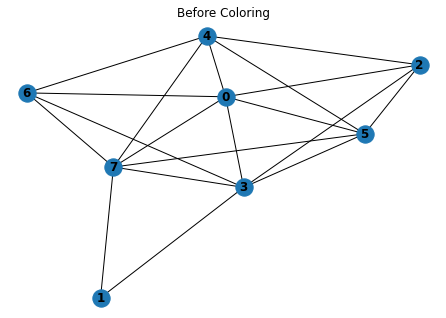

Current Mid (number of colors) is 5
['x00', 'x01', 'x02', 'x03', 'x04', 'x10', 'x11', 'x12', 'x13', 'x14', 'x20', 'x21', 'x22', 'x23', 'x24', 'x30', 'x31', 'x32', 'x33', 'x34', 'x40', 'x41', 'x42', 'x43', 'x44', 'x50', 'x51', 'x52', 'x53', 'x54', 'x60', 'x61', 'x62', 'x63', 'x64', 'x70', 'x71', 'x72', 'x73', 'x74']
Before u1 length 3464
After u1 length 3457
Solution exists for 5 colors
Current Mid (number of colors) is 3
['x00', 'x01', 'x02', 'x10', 'x11', 'x12', 'x20', 'x21', 'x22', 'x30', 'x31', 'x32', 'x40', 'x41', 'x42', 'x50', 'x51', 'x52', 'x60', 'x61', 'x62', 'x70', 'x71', 'x72']
Before u1 length 1
After u1 length 1
No Solution for 3 colors
Current Mid (number of colors) is 4
['x00', 'x01', 'x02', 'x03', 'x10', 'x11', 'x12', 'x13', 'x20', 'x21', 'x22', 'x23', 'x30', 'x31', 'x32', 'x33', 'x40', 'x41', 'x42', 'x43', 'x50', 'x51', 'x52', 'x53', 'x60', 'x61', 'x62', 'x63', 'x70', 'x71', 'x72', 'x73']
Before u1 length 465
After u1 length 296
Solution exists for 4 colors
Minimum numbe

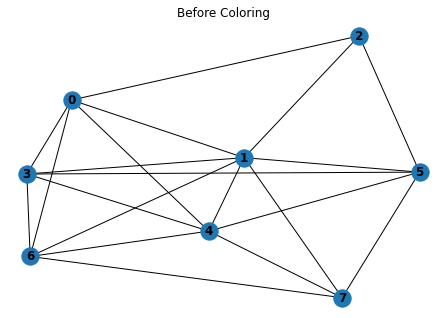

Current Mid (number of colors) is 5
['x00', 'x01', 'x02', 'x03', 'x04', 'x10', 'x11', 'x12', 'x13', 'x14', 'x20', 'x21', 'x22', 'x23', 'x24', 'x30', 'x31', 'x32', 'x33', 'x34', 'x40', 'x41', 'x42', 'x43', 'x44', 'x50', 'x51', 'x52', 'x53', 'x54', 'x60', 'x61', 'x62', 'x63', 'x64', 'x70', 'x71', 'x72', 'x73', 'x74']
Before u1 length 2597
After u1 length 1675
Solution exists for 5 colors
Current Mid (number of colors) is 3
['x00', 'x01', 'x02', 'x10', 'x11', 'x12', 'x20', 'x21', 'x22', 'x30', 'x31', 'x32', 'x40', 'x41', 'x42', 'x50', 'x51', 'x52', 'x60', 'x61', 'x62', 'x70', 'x71', 'x72']
Before u1 length 1
After u1 length 1
No Solution for 3 colors
Current Mid (number of colors) is 4
['x00', 'x01', 'x02', 'x03', 'x10', 'x11', 'x12', 'x13', 'x20', 'x21', 'x22', 'x23', 'x30', 'x31', 'x32', 'x33', 'x40', 'x41', 'x42', 'x43', 'x50', 'x51', 'x52', 'x53', 'x60', 'x61', 'x62', 'x63', 'x70', 'x71', 'x72', 'x73']
Before u1 length 1
After u1 length 1
No Solution for 4 colors
Minimum number of col

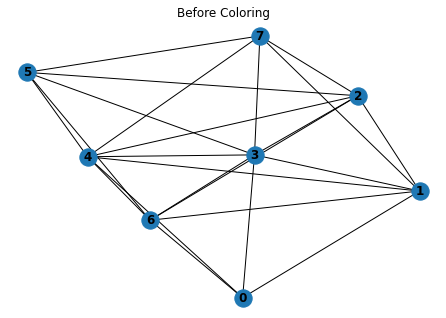

Current Mid (number of colors) is 5
['x00', 'x01', 'x02', 'x03', 'x04', 'x10', 'x11', 'x12', 'x13', 'x14', 'x20', 'x21', 'x22', 'x23', 'x24', 'x30', 'x31', 'x32', 'x33', 'x34', 'x40', 'x41', 'x42', 'x43', 'x44', 'x50', 'x51', 'x52', 'x53', 'x54', 'x60', 'x61', 'x62', 'x63', 'x64', 'x70', 'x71', 'x72', 'x73', 'x74']
Before u1 length 672
After u1 length 433
Solution exists for 5 colors
Current Mid (number of colors) is 3
['x00', 'x01', 'x02', 'x10', 'x11', 'x12', 'x20', 'x21', 'x22', 'x30', 'x31', 'x32', 'x40', 'x41', 'x42', 'x50', 'x51', 'x52', 'x60', 'x61', 'x62', 'x70', 'x71', 'x72']
Before u1 length 1
After u1 length 1
No Solution for 3 colors
Current Mid (number of colors) is 4
['x00', 'x01', 'x02', 'x03', 'x10', 'x11', 'x12', 'x13', 'x20', 'x21', 'x22', 'x23', 'x30', 'x31', 'x32', 'x33', 'x40', 'x41', 'x42', 'x43', 'x50', 'x51', 'x52', 'x53', 'x60', 'x61', 'x62', 'x63', 'x70', 'x71', 'x72', 'x73']
Before u1 length 1
After u1 length 1
No Solution for 4 colors
Minimum number of color

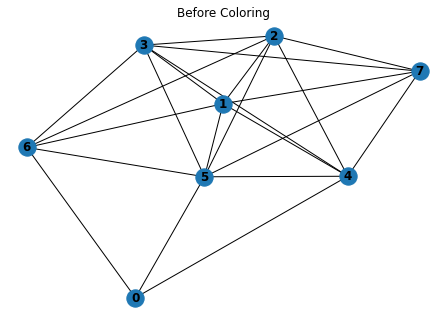

Current Mid (number of colors) is 5
['x00', 'x01', 'x02', 'x03', 'x04', 'x10', 'x11', 'x12', 'x13', 'x14', 'x20', 'x21', 'x22', 'x23', 'x24', 'x30', 'x31', 'x32', 'x33', 'x34', 'x40', 'x41', 'x42', 'x43', 'x44', 'x50', 'x51', 'x52', 'x53', 'x54', 'x60', 'x61', 'x62', 'x63', 'x64', 'x70', 'x71', 'x72', 'x73', 'x74']
Before u1 length 1
After u1 length 1
No Solution for 5 colors
Current Mid (number of colors) is 7
['x00', 'x01', 'x02', 'x03', 'x04', 'x05', 'x06', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76']
Before u1 length 11654
After u1 length 6898
Solution exists for 7 colors
Current Mid (number of colors) is 6
['x00', 'x01', 'x02', 'x03', 'x04', 'x05', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15'

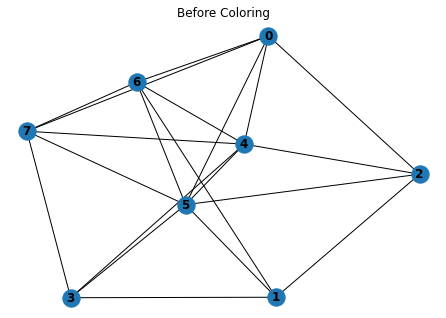

Current Mid (number of colors) is 5
['x00', 'x01', 'x02', 'x03', 'x04', 'x10', 'x11', 'x12', 'x13', 'x14', 'x20', 'x21', 'x22', 'x23', 'x24', 'x30', 'x31', 'x32', 'x33', 'x34', 'x40', 'x41', 'x42', 'x43', 'x44', 'x50', 'x51', 'x52', 'x53', 'x54', 'x60', 'x61', 'x62', 'x63', 'x64', 'x70', 'x71', 'x72', 'x73', 'x74']
Before u1 length 3216
After u1 length 2843
Solution exists for 5 colors
Current Mid (number of colors) is 3
['x00', 'x01', 'x02', 'x10', 'x11', 'x12', 'x20', 'x21', 'x22', 'x30', 'x31', 'x32', 'x40', 'x41', 'x42', 'x50', 'x51', 'x52', 'x60', 'x61', 'x62', 'x70', 'x71', 'x72']
Before u1 length 1
After u1 length 1
No Solution for 3 colors
Current Mid (number of colors) is 4
['x00', 'x01', 'x02', 'x03', 'x10', 'x11', 'x12', 'x13', 'x20', 'x21', 'x22', 'x23', 'x30', 'x31', 'x32', 'x33', 'x40', 'x41', 'x42', 'x43', 'x50', 'x51', 'x52', 'x53', 'x60', 'x61', 'x62', 'x63', 'x70', 'x71', 'x72', 'x73']
Before u1 length 1
After u1 length 1
No Solution for 4 colors
Minimum number of col

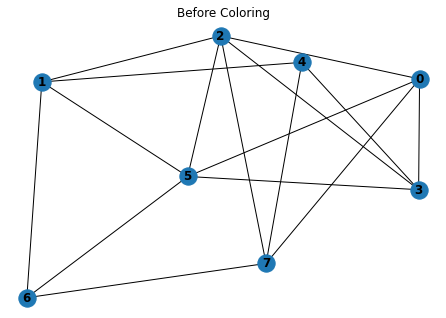

Current Mid (number of colors) is 5
['x00', 'x01', 'x02', 'x03', 'x04', 'x10', 'x11', 'x12', 'x13', 'x14', 'x20', 'x21', 'x22', 'x23', 'x24', 'x30', 'x31', 'x32', 'x33', 'x34', 'x40', 'x41', 'x42', 'x43', 'x44', 'x50', 'x51', 'x52', 'x53', 'x54', 'x60', 'x61', 'x62', 'x63', 'x64', 'x70', 'x71', 'x72', 'x73', 'x74']
Before u1 length 4830
After u1 length 3876
Solution exists for 5 colors
Current Mid (number of colors) is 3
['x00', 'x01', 'x02', 'x10', 'x11', 'x12', 'x20', 'x21', 'x22', 'x30', 'x31', 'x32', 'x40', 'x41', 'x42', 'x50', 'x51', 'x52', 'x60', 'x61', 'x62', 'x70', 'x71', 'x72']
Before u1 length 1
After u1 length 1
No Solution for 3 colors
Current Mid (number of colors) is 4
['x00', 'x01', 'x02', 'x03', 'x10', 'x11', 'x12', 'x13', 'x20', 'x21', 'x22', 'x23', 'x30', 'x31', 'x32', 'x33', 'x40', 'x41', 'x42', 'x43', 'x50', 'x51', 'x52', 'x53', 'x60', 'x61', 'x62', 'x63', 'x70', 'x71', 'x72', 'x73']
Before u1 length 960
After u1 length 766
Solution exists for 4 colors
Minimum numbe

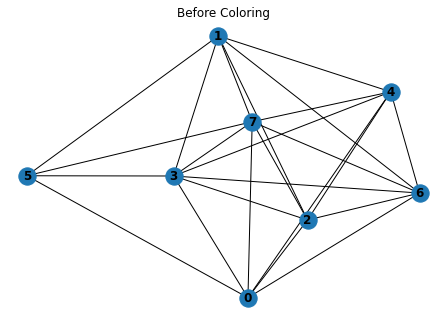

Current Mid (number of colors) is 5
['x00', 'x01', 'x02', 'x03', 'x04', 'x10', 'x11', 'x12', 'x13', 'x14', 'x20', 'x21', 'x22', 'x23', 'x24', 'x30', 'x31', 'x32', 'x33', 'x34', 'x40', 'x41', 'x42', 'x43', 'x44', 'x50', 'x51', 'x52', 'x53', 'x54', 'x60', 'x61', 'x62', 'x63', 'x64', 'x70', 'x71', 'x72', 'x73', 'x74']
Before u1 length 1
After u1 length 1
No Solution for 5 colors
Current Mid (number of colors) is 7
['x00', 'x01', 'x02', 'x03', 'x04', 'x05', 'x06', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76']
Before u1 length 9939
After u1 length 9939
Solution exists for 7 colors
Current Mid (number of colors) is 6
['x00', 'x01', 'x02', 'x03', 'x04', 'x05', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15',

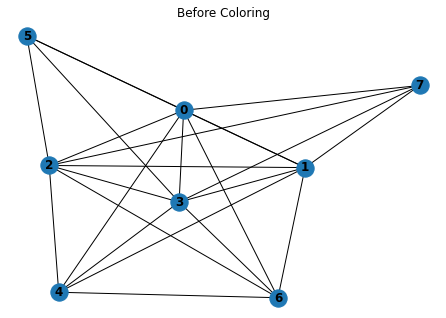

Current Mid (number of colors) is 5
['x00', 'x01', 'x02', 'x03', 'x04', 'x10', 'x11', 'x12', 'x13', 'x14', 'x20', 'x21', 'x22', 'x23', 'x24', 'x30', 'x31', 'x32', 'x33', 'x34', 'x40', 'x41', 'x42', 'x43', 'x44', 'x50', 'x51', 'x52', 'x53', 'x54', 'x60', 'x61', 'x62', 'x63', 'x64', 'x70', 'x71', 'x72', 'x73', 'x74']
Before u1 length 1
After u1 length 1
No Solution for 5 colors
Current Mid (number of colors) is 7
['x00', 'x01', 'x02', 'x03', 'x04', 'x05', 'x06', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76']
Before u1 length 3366
After u1 length 2596
Solution exists for 7 colors
Current Mid (number of colors) is 6
['x00', 'x01', 'x02', 'x03', 'x04', 'x05', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15',

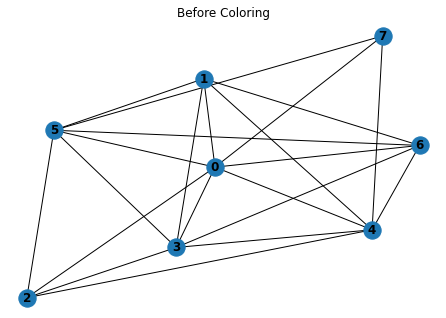

Current Mid (number of colors) is 5
['x00', 'x01', 'x02', 'x03', 'x04', 'x10', 'x11', 'x12', 'x13', 'x14', 'x20', 'x21', 'x22', 'x23', 'x24', 'x30', 'x31', 'x32', 'x33', 'x34', 'x40', 'x41', 'x42', 'x43', 'x44', 'x50', 'x51', 'x52', 'x53', 'x54', 'x60', 'x61', 'x62', 'x63', 'x64', 'x70', 'x71', 'x72', 'x73', 'x74']
Before u1 length 1725
After u1 length 876
Solution exists for 5 colors
Current Mid (number of colors) is 3
['x00', 'x01', 'x02', 'x10', 'x11', 'x12', 'x20', 'x21', 'x22', 'x30', 'x31', 'x32', 'x40', 'x41', 'x42', 'x50', 'x51', 'x52', 'x60', 'x61', 'x62', 'x70', 'x71', 'x72']
Before u1 length 1
After u1 length 1
No Solution for 3 colors
Current Mid (number of colors) is 4
['x00', 'x01', 'x02', 'x03', 'x10', 'x11', 'x12', 'x13', 'x20', 'x21', 'x22', 'x23', 'x30', 'x31', 'x32', 'x33', 'x40', 'x41', 'x42', 'x43', 'x50', 'x51', 'x52', 'x53', 'x60', 'x61', 'x62', 'x63', 'x70', 'x71', 'x72', 'x73']
Before u1 length 1
After u1 length 1
No Solution for 4 colors
Minimum number of colo

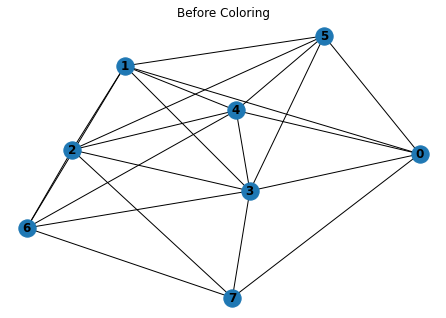

Current Mid (number of colors) is 5
['x00', 'x01', 'x02', 'x03', 'x04', 'x10', 'x11', 'x12', 'x13', 'x14', 'x20', 'x21', 'x22', 'x23', 'x24', 'x30', 'x31', 'x32', 'x33', 'x34', 'x40', 'x41', 'x42', 'x43', 'x44', 'x50', 'x51', 'x52', 'x53', 'x54', 'x60', 'x61', 'x62', 'x63', 'x64', 'x70', 'x71', 'x72', 'x73', 'x74']
Before u1 length 878
After u1 length 776
Solution exists for 5 colors
Current Mid (number of colors) is 3
['x00', 'x01', 'x02', 'x10', 'x11', 'x12', 'x20', 'x21', 'x22', 'x30', 'x31', 'x32', 'x40', 'x41', 'x42', 'x50', 'x51', 'x52', 'x60', 'x61', 'x62', 'x70', 'x71', 'x72']
Before u1 length 1
After u1 length 1
No Solution for 3 colors
Current Mid (number of colors) is 4
['x00', 'x01', 'x02', 'x03', 'x10', 'x11', 'x12', 'x13', 'x20', 'x21', 'x22', 'x23', 'x30', 'x31', 'x32', 'x33', 'x40', 'x41', 'x42', 'x43', 'x50', 'x51', 'x52', 'x53', 'x60', 'x61', 'x62', 'x63', 'x70', 'x71', 'x72', 'x73']
Before u1 length 1
After u1 length 1
No Solution for 4 colors
Minimum number of color

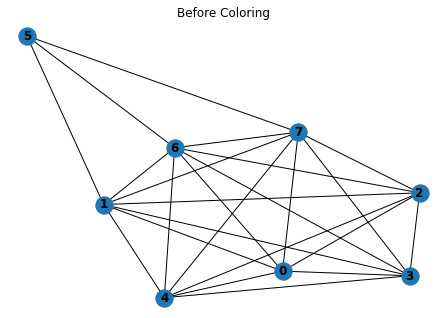

Current Mid (number of colors) is 5
['x00', 'x01', 'x02', 'x03', 'x04', 'x10', 'x11', 'x12', 'x13', 'x14', 'x20', 'x21', 'x22', 'x23', 'x24', 'x30', 'x31', 'x32', 'x33', 'x34', 'x40', 'x41', 'x42', 'x43', 'x44', 'x50', 'x51', 'x52', 'x53', 'x54', 'x60', 'x61', 'x62', 'x63', 'x64', 'x70', 'x71', 'x72', 'x73', 'x74']
Before u1 length 1
After u1 length 1
No Solution for 5 colors
Current Mid (number of colors) is 7
['x00', 'x01', 'x02', 'x03', 'x04', 'x05', 'x06', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76']
Before u1 length 4526
After u1 length 4526
Solution exists for 7 colors
Current Mid (number of colors) is 6
['x00', 'x01', 'x02', 'x03', 'x04', 'x05', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15',

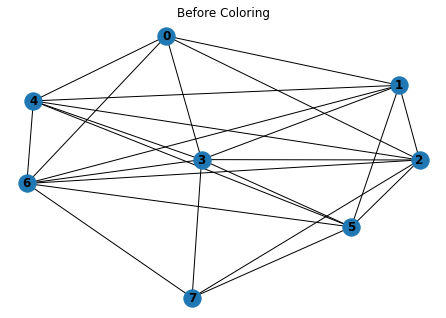

Current Mid (number of colors) is 5
['x00', 'x01', 'x02', 'x03', 'x04', 'x10', 'x11', 'x12', 'x13', 'x14', 'x20', 'x21', 'x22', 'x23', 'x24', 'x30', 'x31', 'x32', 'x33', 'x34', 'x40', 'x41', 'x42', 'x43', 'x44', 'x50', 'x51', 'x52', 'x53', 'x54', 'x60', 'x61', 'x62', 'x63', 'x64', 'x70', 'x71', 'x72', 'x73', 'x74']
Before u1 length 1
After u1 length 1
No Solution for 5 colors
Current Mid (number of colors) is 7
['x00', 'x01', 'x02', 'x03', 'x04', 'x05', 'x06', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76']
Before u1 length 15959
After u1 length 15959
Solution exists for 7 colors
Current Mid (number of colors) is 6
['x00', 'x01', 'x02', 'x03', 'x04', 'x05', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15

In [24]:
density_list = [0.8, 0.95, 0.99]
Nstart = 8
Nend = 8
Nstep = 1
runs = 5

exec_times_N_d = []
chr_num_N_min = []
chr_num_N_max = []
chr_num_N_avg = []
exec_time_per_N = []

for N in range (Nstart, Nend+1, Nstep): 
    
    exec_time_for_d = []
    chr_num_per_d_min = []
    chr_num_per_d_max = []
    chr_num_per_d_avg = []
    
    for d in density_list:
        Chr_num_per_run= []        
        start = time.time()        
        for k in range(runs):
            edges.clear()
            
            print(" ############################# N =", N, "d =", d, "Run =", k+1, "###############################")
            N, M, edges = randgraph(N,d)
            G = nx.Graph()
            G.add_edges_from(edges)
            G.add_nodes_from([i for i in range(0,N)])
            nx.draw(G, with_labels=True, font_weight='bold')
            plt.title('Before Coloring')
            plt.show() 

           # IDEA is to iteratively search for minimum number of colors that can still satisfy the constraints

            # Best solution is binary search, keep going left until left > right
            left = 2
            right = N
            mid = int(N/2)
            min_color_soln = N

            while left <= right :  
                """
                Construct the BDD for allowed number of colors
                """    

                mid = int ((left + right) /2 )
                num_colors = mid
                print("Current Mid (number of colors) is", mid)

                string = ''
                mgr3 = BDD()
                variables = ['x{i}{j}'.format(i=i, j=j) for i in range(N) for j in range(num_colors)]
                # variables.extend('y{i}'.format(i=i) for i in range(N))
                print(variables)
                mgr3.declare(*variables)
                mgr3.vars #prints variable names and the relevent bdd level

                
                # Color definedeness per node constraint
                for i in range(N):
                    clause = '('
                    clause += 'x{i}{j}'.format(i=i, j= 0)
                    for j in range(1, num_colors):
                        clause += ' | ' + 'x{i}{j}'.format(i=i, j=j)
                    clause += ')'  
                    if i==0 :
                        string += clause
                    else:
                        string += ' & ' + clause
                    
                # Color uniqueness per node constraint  
                for i in range(N):
                    for j in range(num_colors):
                        for k in range(j+1, num_colors):
                            # if i== 0 and j==0 and k==1:
                            #    string += '(!x{i}{j} | !x{i}{k})'.format(i=i, j=j, k=k)
                            # else:
                            string += ' & ' + '(!x{i}{j} | !x{i}{k})'.format(i=i, j=j, k=k)

                """ 
                # Color definedeness per node constraint
                for i in range(N):
                    clause = '('
                    clause += 'x{i}{j}'.format(i=i, j= 0)
                    for j in range(1, num_colors):
                        clause += ' | ' + 'x{i}{j}'.format(i=i, j=j)
                    clause += ')'    
                    string += ' & ' + clause
                """
                # Constraint 3: For all edges: no two vertex share same colour
                for e in edges:
                    # e[0] -> gives left-vertex, e[1] -> gives right-vertex
                    clause = ''
                    for k in range(num_colors):
                        clause = '!(x{i}{k} & x{j}{k})'.format(i=e[0], j=e[1], k=k)
                        string += ' & ' + clause

                # print(string)
                u1= mgr3.add_expr(string)
                print("Before u1 length", len(u1))
                BDD.reorder(mgr3)
                print("After u1 length", len(u1))
                # print(u1)

                if u1.to_expr() != "FALSE":
                    print("Solution exists for {n} colors".format(n= num_colors))
                    right = mid - 1 
                    if mid< min_color_soln:
                        min_color_soln = mid
                        # mgr3.dump('test.pdf')
                else:
                    print("No Solution for {n} colors".format(n= num_colors))
                    left = mid + 1

                mgr3.collect_garbage()
            
            print("Minimum number of colors for this graph is", min_color_soln)
            print("Last num of colors tried: ", mid)
        
            Chr_num_per_run.append(min_color_soln)
            
        end_time = time.time()
        exec_time = end_time - start
        exec_time_for_d.append(exec_time/ runs)
        
        chr_num_per_d_min.append(min(Chr_num_per_run))
        chr_num_per_d_max.append(max(Chr_num_per_run))
        chr_num_per_d_avg.append(np.mean(Chr_num_per_run))
        
    chr_num_N_min.append(chr_num_per_d_min)
    chr_num_N_max.append(chr_num_per_d_max)
    chr_num_N_avg.append(chr_num_per_d_avg)  
    exec_times_N_d.append(exec_time_for_d)
      

In [25]:
exec_times_N_d

[[8.227045345306397, 11.747787427902221, 11.694679069519044]]

In [26]:
X = [density_list for i in range(Nstart, Nend +1, Nstep)]
X

[[0.8, 0.95, 0.99]]

############### EXECUTION TIME PLOTS #################


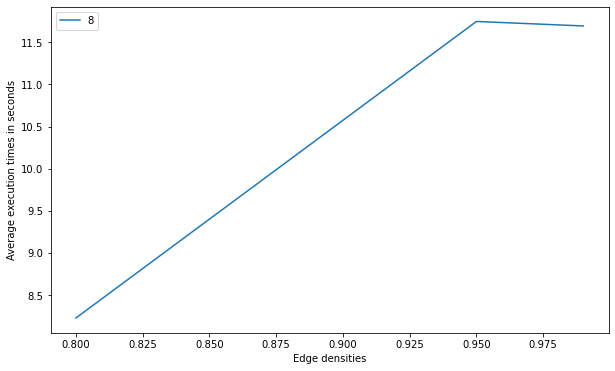

############### Min chromatic number PLOTS #################


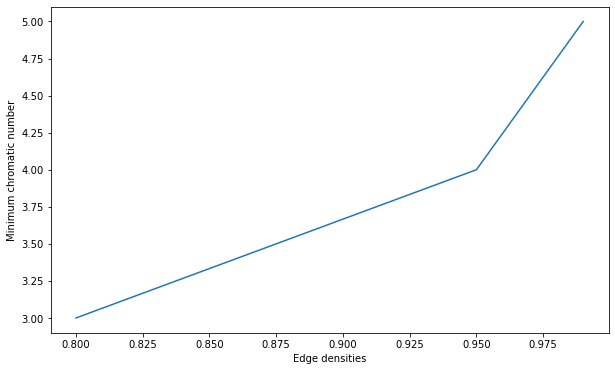

############### Max chromatic number PLOTS #################


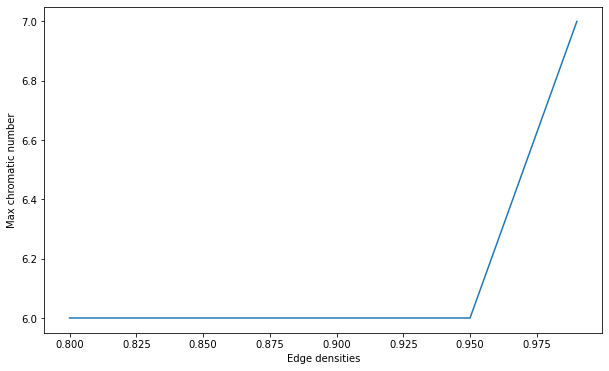

############### Avg chromatic number PLOTS #################


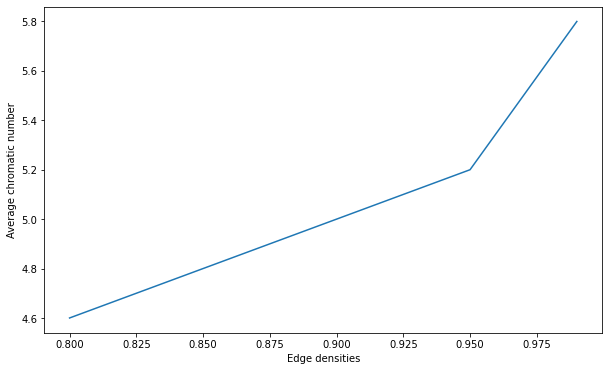

In [27]:
try:
    import matplotlib.pyplot as plt
    from pylab import rcParams
    %matplotlib inline
    rcParams['figure.figsize'] = 10, 6
    
    # First plot : Execution times
    
    print ( "############### EXECUTION TIME PLOTS #################" )
    plt.figure()
    for i in range(len(X)):
        plt.plot(X[i], exec_times_N_d[i], label='N= %d' %(Nstart +Nstep*i) )
    plt.xlabel('Edge densities')
    plt.ylabel('Average execution times in seconds')
    plt.legend([i for i in range(Nstart, Nend +1, Nstep)])
    plt.show()
    
        # First plot : Minimum chromatic number
    
    print ( "############### Min chromatic number PLOTS #################" )
    plt.figure()
    for i in range(len(X)):
        plt.plot(X[i], chr_num_N_min[i], label='N= %d' %(Nstart +Nstep*i) )
    plt.xlabel('Edge densities')
    plt.ylabel('Minimum chromatic number')
    plt.show()
    
            # First plot : Maximum chromatic number
    
    print ( "############### Max chromatic number PLOTS #################" )
    plt.figure()
    for i in range(len(X)):
        plt.plot(X[i], chr_num_N_max[i], label='N= %d' %(Nstart +Nstep*i) )
    plt.xlabel('Edge densities')
    plt.ylabel('Max chromatic number')
    plt.show()
    
            # First plot : Average chromatic number
    
    print ( "############### Avg chromatic number PLOTS #################" )
    plt.figure()
    for i in range(len(X)):
        plt.plot(X[i], chr_num_N_avg[i], label='N= %d' %(Nstart +Nstep*i) )
    plt.xlabel('Edge densities')
    plt.ylabel('Average chromatic number')
    plt.show()
    

except ImportError:
    print("matplotlib not found, nothing will be displayed")
    plt = None
    def display_solution(sol):   pass

In [28]:
"""

OBSERVATION: Definedness constraint before Uniqueness constraint gives lesser BDD size. Keeping "unique colors of vertices of edge" constraint
at the top has no additional improvement. 
Initial intuition: The target is to cut down search space by introducing variables first that impact the entire BDD to be traversed.

"""

'\n\nOBSERVATION: Definedness constraint before Uniqueness constraint gives lesser BDD size. Keeping "unique colors of vertices of edge" constraint\nat the top has no additional improvement. \nInitial intuition: The target is to cut down search space by introducing variables first that impact the entire BDD to be traversed.\n\n'

In [29]:
"""
uniqueness constraint removed
"""
N = 8
edges= [[0,1],[0,3],[0,4],[1,2],[1,6],[2,5],[2,6],[3,5],[4,7],[5,6],[6,7]]

# IDEA is to iteratively search for minimum number of colors that can still satisfy the constraints

# Best solution is binary search, keep going left until left > right
left = 2
right = N
mid = int(N/2)
min_color_soln = N

while left <= right :  
    """
    Construct the BDD for allowed number of colors
    """    
    
    mid = int ((left + right) /2 )
    num_colors = mid
    print("Current Mid (number of colors) is", mid)
    
    string = ''
    mgr3 = BDD()
    variables = ['x{i}{j}'.format(i=i, j=j) for i in range(N) for j in range(num_colors)]
    # variables.extend('y{i}'.format(i=i) for i in range(N))
    print(variables)
    mgr3.declare(*variables)
    mgr3.vars #prints variable names and the relevent bdd level
    
    # Color definedeness per node constraint
    for i in range(N):
        clause = '('
        clause += 'x{i}{j}'.format(i=i, j= 0)
        for j in range(1, num_colors):
            clause += ' | ' + 'x{i}{j}'.format(i=i, j=j)
        clause += ')'  
        if i==0 :
            string += clause
        else:
            string += ' & ' + clause

    # Constraint 3: For all edges: no two vertex share same colour
    for e in edges:
        # e[0] -> gives left-vertex, e[1] -> gives right-vertex
        clause = ''
        for k in range(num_colors):
            clause = '!(x{i}{k} & x{j}{k})'.format(i=e[0], j=e[1], k=k)
            string += ' & ' + clause
            
    print(string)
    u1= mgr3.add_expr(string)
    print("Before size", len(u1))
    BDD.reorder(mgr3)
    print("After size", len(u1))
    print(u1)
    
    if u1.to_expr() != "FALSE":
        print("Solution exists for {n} colors".format(n= num_colors))
        right = mid - 1 
        if mid< min_color_soln:
            min_color_soln = mid
            # mgr3.dump('test.pdf')
    else:
        print("No Solution for {n} colors".format(n= num_colors))
        left = mid + 1
    
    mgr3.collect_garbage()
    
print("Last num of colors tried: ", mid)

Current Mid (number of colors) is 5
['x00', 'x01', 'x02', 'x03', 'x04', 'x10', 'x11', 'x12', 'x13', 'x14', 'x20', 'x21', 'x22', 'x23', 'x24', 'x30', 'x31', 'x32', 'x33', 'x34', 'x40', 'x41', 'x42', 'x43', 'x44', 'x50', 'x51', 'x52', 'x53', 'x54', 'x60', 'x61', 'x62', 'x63', 'x64', 'x70', 'x71', 'x72', 'x73', 'x74']
(x00 | x01 | x02 | x03 | x04) & (x10 | x11 | x12 | x13 | x14) & (x20 | x21 | x22 | x23 | x24) & (x30 | x31 | x32 | x33 | x34) & (x40 | x41 | x42 | x43 | x44) & (x50 | x51 | x52 | x53 | x54) & (x60 | x61 | x62 | x63 | x64) & (x70 | x71 | x72 | x73 | x74) & !(x00 & x10) & !(x01 & x11) & !(x02 & x12) & !(x03 & x13) & !(x04 & x14) & !(x00 & x30) & !(x01 & x31) & !(x02 & x32) & !(x03 & x33) & !(x04 & x34) & !(x00 & x40) & !(x01 & x41) & !(x02 & x42) & !(x03 & x43) & !(x04 & x44) & !(x10 & x20) & !(x11 & x21) & !(x12 & x22) & !(x13 & x23) & !(x14 & x24) & !(x10 & x60) & !(x11 & x61) & !(x12 & x62) & !(x13 & x63) & !(x14 & x64) & !(x20 & x50) & !(x21 & x51) & !(x22 & x52) & !(x23 &

In [30]:
"""
OBSERVATION: REMOVING UNIQUENESS CONSTRAITNS YIELDS EXPLODED BDD SIZE for larger number of colors; not so much for smaller number of colors. 
The suspected reason is the number of free variables (i.e. permutations) that can be true and not being evaluated for a concerned ITE evaluation
are huge. Hence, listing all of the possible cases as ITE explodes the listing space, factorially for larger number of colors. 
"""

'\nOBSERVATION: REMOVING UNIQUENESS CONSTRAITNS YIELDS EXPLODED BDD SIZE for larger number of colors; not so much for smaller number of colors. \nThe suspected reason is the number of free variables (i.e. permutations) that can be true and not being evaluated for a concerned ITE evaluation\nare huge. Hence, listing all of the possible cases as ITE explodes the listing space, factorially for larger number of colors. \n'

In [31]:
"""
CLIQUE COLORING IMPLMENTATION FOR NODE SIZES: 14, 16, ,18, 20 BELOW. PERFORMANCE ANALYSIS RESULTS FOLLOW.

NOTE1: My precoloring recursive use of BDD coloring scheme given that my clique is not fully connected. Although a recursive algo could be
formulated to recursively color the smaller groups that have larger number of connections.

NOTE: EVEN AFTER CLIQUE COLORING, EXECUTION TIMES FOR BDD are quite high
"""

'\nCLIQUE COLORING IMPLMENTATION FOR NODE SIZES: 14, 16, ,18, 20 BELOW. PERFORMANCE ANALYSIS RESULTS FOLLOW.\n\nNOTE1: My precoloring recursive use of BDD coloring scheme given that my clique is not fully connected. Although a recursive algo could be\nformulated to recursively color the smaller groups that have larger number of connections.\n\nNOTE: EVEN AFTER CLIQUE COLORING, EXECUTION TIMES FOR BDD are quite high\n'

In [54]:
"""Not a perfect implmentation: but a perfect implmentation requires lot of case checking and loops"""

def clq_find(Adj, N):
    
    lst = [i for i in range(N)]
    clq_lst = []
    max_sum= 0
    clique_start_node = 0
    for i in range(len(Adj)) :
        Sum = sum(Adj[i])
    #     print(Sum)
        if Sum > max_sum:
            max_sum = Sum
            clique_start_node = i

    # print("Clique start Node is", clique_start_node)    
    clq_lst.append(clique_start_node)
    lst.remove(clique_start_node)
    
    for node in lst:
        flag = 1
        # print("Node is", node)        
        for clq_node in clq_lst:
            # print("Clique node", clq_node)
            if Adj[node][clq_node] == 0:
                flag = 0
                # print("Not selected")
                break      
        if flag == 1:
            # print("Selected")
            clq_lst.append(node)
            lst.remove(node)
            
    return clq_lst, lst

In [62]:
def color_via_BDD(edges, lst, pre_color_lst):
    
# IDEA is to iteratively search for minimum number of colors that can still satisfy the constraints
# Best solution is binary search, keep going left until left > right
    
    print("LST is", lst)
    
    left = 2
    right = N
    mid = int(N/2)
    min_color_soln = N

    while left <= right :  
        """
        Construct the BDD for allowed number of colors
        """            
        
        mid = int ((left + right) /2 )
        num_colors = mid
        print("Current Mid (number of colors) is", mid)

        string = ''
        mgr3 = BDD()
        variables = ['x{i}{j}'.format(i=i, j=j) for i in lst for j in range(num_colors)]
        print(variables)
        mgr3.declare(*variables)
        mgr3.vars #prints variable names and the relevent bdd level
        
        """
        PRE COLORATION ADDITION -- FACING PROBLEMS HERE LAST
        """                
        # Fix colors for pre_colored nodes
        for i, val in enumerate(pre_color_lst):
            print("Here", i, val)
            if i == 0:
                string += '(' + val + ')'
            else:
                string += ' & ' + '(' + val + ')'
        
        # Color definedeness per node constraint
        for i in lst:
            clause = '('
            clause += 'x{i}{j}'.format(i=i, j= 0)
            for j in range(1, num_colors):
                clause += ' | ' + 'x{i}{j}'.format(i=i, j=j)
            clause += ')'
            if not string :
                string += clause
            else:
                string += ' & ' + clause

        # Color uniqueness per node constraint  
        for i in lst:
            for j in range(num_colors):
                for k in range(j+1, num_colors):
                    string += ' & ' + '(!x{i}{j} | !x{i}{k})'.format(i=i, j=j, k=k)


        # Constraint 3: For all edges: no two vertex share same colour
        for e in edges:
            # e[0] -> gives left-vertex, e[1] -> gives right-vertex
            clause = ''
            for k in range(num_colors):
                clause = '!(x{i}{k} & x{j}{k})'.format(i=e[0], j=e[1], k=k)
                string += ' & ' + clause

        print(string)
        u1= mgr3.add_expr(string)
        print("Before u1 length", len(u1))
        BDD.reorder(mgr3)
        print("After u1 length", len(u1))
        # print(u1)

        if u1.to_expr() != "FALSE":
            print("Solution exists for {n} colors".format(n= num_colors))
            right = mid - 1 
            if mid< min_color_soln:
                min_color_soln = mid
                # mgr3.dump('test.pdf')
                models = list(mgr3.pick_iter(u1))
        else:
            print("No Solution for {n} colors".format(n= num_colors))
            left = mid + 1

        mgr3.collect_garbage()
    
    return min_color_soln, models[0]

In [63]:
def pre_color(clq_lst):
    
    pre_color_lst = []
    pre_color_dict = {}
    color = 0
    for node in clq_lst:
        pre_color_lst.append('x{i}{j}'.format(i= node, j = color))
        color += 1
        pre_color_dict[node] = color
    
    return pre_color_lst, pre_color_dict

 ############################# N = 8 d = 0.8 Run = 1 ###############################


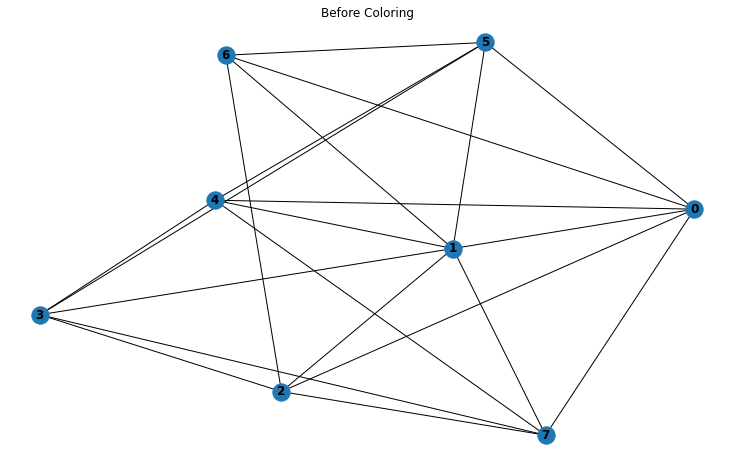

[[0. 1. 1. 1. 1. 0. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 1. 1. 1. 0.]
 [1. 1. 0. 0. 1. 1. 0. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 1. 1.]
 [1. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 1. 1. 0.]]
clique_list is [1, 0, 3, 7]
non_clique list is [2, 4, 5, 6]
clq_edges [[0, 1], [1, 0], [3, 1], [7, 0], [7, 1], [7, 3]]
Minimum number of colors for clique is (onebased indexing) 5
Pre_color_list is ['x10', 'x01', 'x32', 'x73']
LST is [2, 4, 5, 6]
Current Mid (number of colors) is 5
['x20', 'x21', 'x22', 'x23', 'x24', 'x40', 'x41', 'x42', 'x43', 'x44', 'x50', 'x51', 'x52', 'x53', 'x54', 'x60', 'x61', 'x62', 'x63', 'x64']
Here 0 x10
Here 1 x01
Here 2 x32
Here 3 x73
(x10) & (x01) & (x32) & (x73) & (x20 | x21 | x22 | x23 | x24) & (x40 | x41 | x42 | x43 | x44) & (x50 | x51 | x52 | x53 | x54) & (x60 | x61 | x62 | x63 | x64) & (!x20 | !x21) & (!x20 | !x22) & (!x20 | !x23) & (!x20 | !x24) & (!x21 | !x22) & (!x21 | !x23) & (!x21 | !x24) & (!x22 | !x23) & (!x22 | !x24) & (!x23 | !x2

AssertionError: undefined variable "x10", known variables are:
 {'x20': 0, 'x21': 1, 'x22': 2, 'x23': 3, 'x24': 4, 'x40': 5, 'x41': 6, 'x42': 7, 'x43': 8, 'x44': 9, 'x50': 10, 'x51': 11, 'x52': 12, 'x53': 13, 'x54': 14, 'x60': 15, 'x61': 16, 'x62': 17, 'x63': 18, 'x64': 19}

In [64]:
density_list = [0.8, 0.9, 0.95]
Nstart = 8
Nend = 8
Nstep = 1
runs = 1

exec_times_N_d = []
chr_num_N_min = []
chr_num_N_max = []
chr_num_N_avg = []
exec_time_per_N = []

for N in range (Nstart, Nend+1, Nstep): 
    
    exec_time_for_d = []
    chr_num_per_d_min = []
    chr_num_per_d_max = []
    chr_num_per_d_avg = []
    
    for d in density_list:
        Chr_num_per_run= []        
        start = time.time()        
        for k in range(runs):
            edges.clear()
            
            print(" ############################# N =", N, "d =", d, "Run =", k+1, "###############################")
            N, M, edges = randgraph(N,d)
            G = nx.Graph()
            G.add_edges_from(edges)
            G.add_nodes_from([i for i in range(0,N)])
            nx.draw(G, with_labels=True, font_weight='bold')
            A = nx.adjacency_matrix(G)
            Adj = nx.to_numpy_array(G)
            plt.title('Before Coloring')
            plt.show() 
            print(Adj)
            
            """Find the Clique"""
            
            clq_lst = []
            non_clq_lst = []
            clq_lst, non_clq_lst = clq_find(Adj, N) 
            clq_edges = []
            for e in edges:
                if (e[0] in clq_lst) and (e[1] in clq_lst) :
                    clq_edges.append(e)
            
            print("clique_list is", clq_lst)
            print("non_clique list is", non_clq_lst)
            print("clq_edges", clq_edges)
            
            """
            Color the clique and call back the colored nodes 
            """
            pre_color_lst, pre_color_dict = pre_color(clq_lst) 
            
            print("Minimum number of colors for clique is (onebased indexing)", len(clq_lst) + 1)
            print("Pre_color_list is", pre_color_lst)
            
            """Color the rest of the graph"""
            color_dict = {}
            
            lst = [i for i in range(N)]
            for key, val in enumerate(pre_color_dict):
                lst.remove(val)
                
            min_color_soln, color_dict = color_via_BDD(edges, lst, pre_color_lst)
            
            print("Minimum number of colors for this graph is", min_color_soln)
            print("Last num of colors tried: ", mid)
        
            Chr_num_per_run.append(min_color_soln)
            
        end_time = time.time()
        exec_time = end_time - start
        exec_time_for_d.append(exec_time/ runs)
        
        chr_num_per_d_min.append(min(Chr_num_per_run))
        chr_num_per_d_max.append(max(Chr_num_per_run))
        chr_num_per_d_avg.append(np.mean(Chr_num_per_run))
        
    chr_num_N_min.append(chr_num_per_d_min)
    chr_num_N_max.append(chr_num_per_d_max)
    chr_num_N_avg.append(chr_num_per_d_avg)  
    exec_times_N_d.append(exec_time_for_d)
